# Stability of HA protein's effect on the evolution of H3N2 influenza

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import itertools
import scipy
from numpy import random

In [60]:
input_file = open("ddg_output.txt", 'r')
viruses = json.load(input_file)
structures = ['2YP2', '2YP7', '1HA0']


## Correlation between sum_ddg

[[ 1.          0.59685918  0.65138986]
 [ 0.59685918  1.          0.92814718]
 [ 0.65138986  0.92814718  1.        ]]


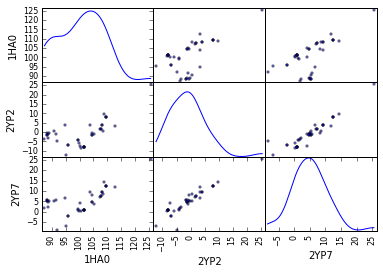

In [59]:
ddg = {}
for structure in structures:
    ddg[structure] = []
for virus in viruses.values():
    for structure in structures:
        ddg[structure].append(virus[structure]['sum_ddg'])
df = pd.DataFrame(ddg, columns=['1HA0', '2YP2', '2YP7'])
from pandas.tools.plotting import scatter_matrix
scatter_matrix(result, alpha=0.5, diagonal='kde')
corr = df.corr().as_matrix()
print(corr)

In [ ]:
for class in ['trunk', 'tip', 'branch']
        class = {}
        ddg[structure] = []